In [1]:
!pip install matplotlib

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from aind_z1_radial_correction import radial_correction
import tensorstore as ts
import time
import numpy as np

scale = "0"

corrected_tile_path = "/results/Tile_X_0000_Y_0000_Z_0000_ch_488.ome.zarr"
raw_tile_path = "/data/HCR_785830_2025-03-19_17-00-00/SPIM/Tile_X_0000_Y_0000_Z_0000_ch_488.ome.zarr"

start_time = time.time()
raw_tile, raw_tile_lazy = await radial_correction.read_zarr_tensorstore(raw_tile_path, scale=scale, driver='zarr')

print(f"Time reading v2: {time.time() - start_time}")

start_time = time.time()
corrected_tile, corrected_tile_lazy = await radial_correction.read_zarr_tensorstore(corrected_tile_path, scale=scale, driver='zarr3')
print(f"Time reading v3: {time.time() - start_time}")

corrected_tile = corrected_tile.squeeze()
raw_tile = raw_tile.squeeze()

print(f"Raw tile shape: {raw_tile.shape} - Corrected tile shape: {corrected_tile.shape}")

Time reading v2: 27.637964725494385
Time reading v3: 5.206590175628662
Raw tile shape: (2961, 1920, 1920) - Corrected tile shape: (2961, 1910, 1910)


In [3]:
pad_width = ((0, 0), (5, 5), (5, 5))
corrected_tile_pad = np.pad(corrected_tile, pad_width=pad_width, mode='constant', constant_values=0)
print("Corrected padded: ", corrected_tile_pad.shape)

Corrected padded:  (2961, 1920, 1920)


In [4]:
print("Raw mean std min max ", raw_tile.mean(), raw_tile.min(), raw_tile.max())
print("Corrected mean std min max ", corrected_tile.mean(), corrected_tile.min(), corrected_tile.max())

Raw mean std min max  621.6769885039989 0 11040
Corrected mean std min max  622.3542548587723 0 11040


# Let's check a slice

The idea is to check the difference between the intensities in raw and radially corrected data.

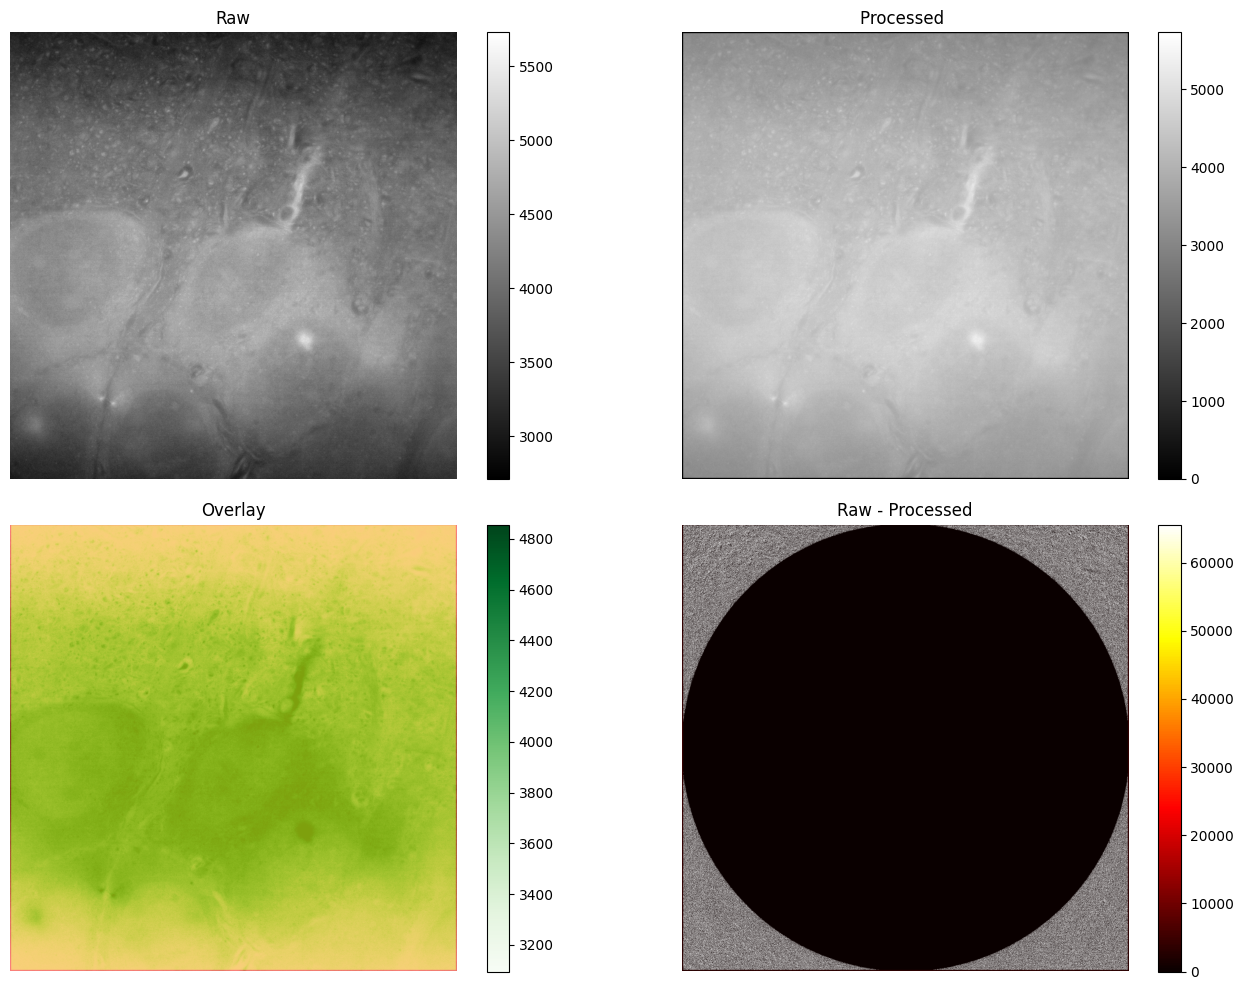

In [5]:
z = 66

raw_slice = raw_tile[z]
processed_slice = corrected_tile_pad[z]

# Normalize both slices for display
def normalize(img):
    return (img - img.min()) / (np.ptp(img) + 1e-8)

raw_norm = raw_slice#normalize(raw_slice)
processed_norm = processed_slice#normalize(processed_slice)

vmin_raw, vmax_raw = np.percentile(raw_norm, (1, 99))
vmin_corr, vmax_corr = np.percentile(processed_norm, (1, 99))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

im = axes[0][0].imshow(raw_norm, cmap='gray')#, vmin=vmin_raw, vmax=vmax_raw)
axes[0][0].set_title('Raw')
axes[0][0].axis('off')
fig.colorbar(im, ax=axes[0][0], fraction=0.046, pad=0.04)

im = axes[1][0].imshow(raw_norm, cmap='Greens', vmin=vmin_raw, vmax=vmax_raw)  # Green for raw
axes[1][0].imshow(processed_norm, cmap='autumn', alpha=0.5, vmin=vmin_corr, vmax=vmax_corr)  # Red-yellow for processed
axes[1][0].set_title('Overlay')
axes[1][0].axis('off')
fig.colorbar(im, ax=axes[1][0], fraction=0.046, pad=0.04)

im = axes[0][1].imshow(processed_norm, cmap='gray')#, vmin=vmin_corr, vmax=vmax_corr)
axes[0][1].set_title('Processed ')
axes[0][1].axis('off')
fig.colorbar(im, ax=axes[0][1], fraction=0.046, pad=0.04)

diff = np.abs(raw_norm - processed_norm)
vmin_diff, vmax_diff = np.percentile(diff, (1, 99))
im = axes[1][1].imshow(diff, cmap='hot', vmin=vmin_diff, vmax=vmax_diff)
axes[1][1].set_title('Raw - Processed')
axes[1][1].axis('off')
fig.colorbar(im, ax=axes[1][1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

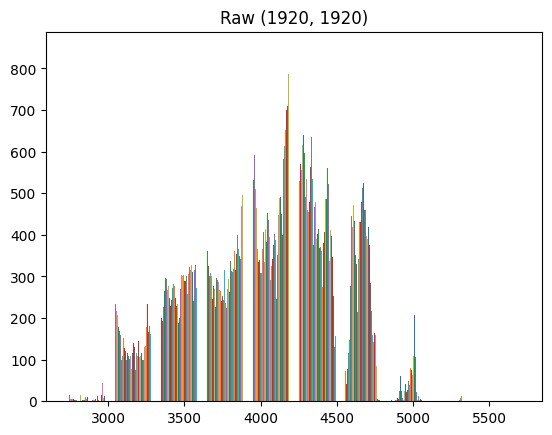

In [7]:
plt.hist(raw_tile[z])#, bins=256)
plt.title(f"Raw {raw_tile[z].shape}")
plt.show()

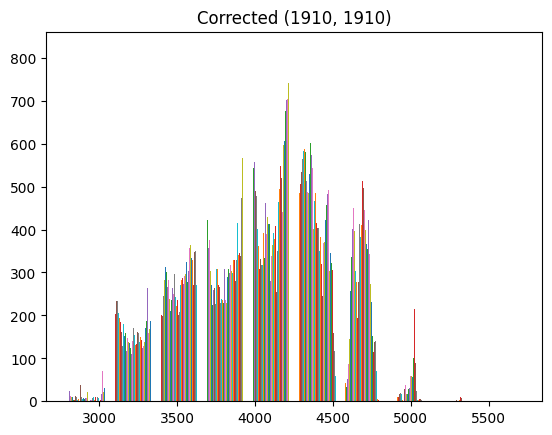

In [8]:
plt.hist(corrected_tile[z])#, bins=256)
plt.title(f"Corrected {corrected_tile[z].shape}")
plt.show()

In [9]:
from matplotlib.patches import Circle

def plot_radial_circles(image, center=None, radii=None, spacing=(1.0, 1.0)):
    if center is None:
        center = (image.shape[0] // 2, image.shape[1] // 2)

    if radii is None:
        max_radius = int(min(image.shape) * 1) # between 0 - 1 to get % of image
        radii = np.arange(10, max_radius, 20)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap='gray')

    for r in radii:
        # Correct for anisotropy by scaling X radius
        circle = Circle(
            (center[1], center[0]),
            radius=r * spacing[1],
            fill=False, color='red', linewidth=1.5, alpha=0.3
        )
        ax.add_patch(circle)

    ax.set_title("Concentric Circles Overlay")
    ax.axis('off')
    plt.show()

def radial_profile_2d(image_2d, center=None):
    # Creating concentric circles
    y, x = np.indices(image_2d.shape)
    if center is None:
        center = np.array(image_2d.shape) // 2

    # Not counting anysotropy here, so must be XY
    # Add parameters sx and sy insiude for anisotropy e.g., (x-center[1])*sx 
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2).astype(int)

    tbin = np.bincount(r.ravel(), image_2d.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = tbin / np.maximum(nr, 1)
    return radial_profile

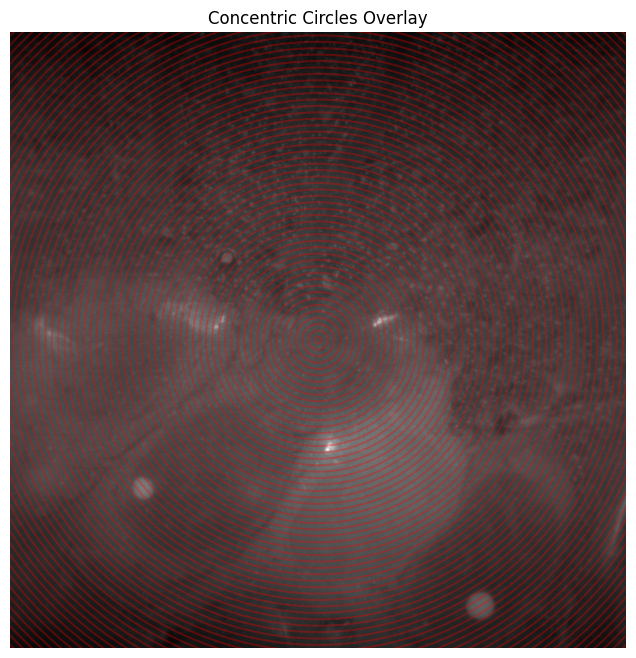

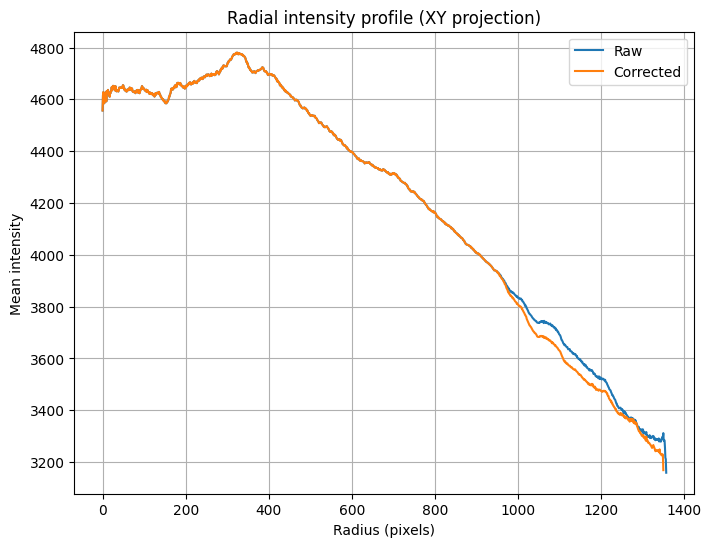

In [10]:
slices = 10
raw_proj = raw_tile[:slices].max(axis=0)  # shape: (Y, X)
corrected_proj = corrected_tile[:slices].max(axis=0)

plot_radial_circles(raw_proj, spacing=(1.0, 1.0))

raw_profile = radial_profile_2d(raw_proj)
corrected_profile = radial_profile_2d(corrected_proj)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(raw_profile, label='Raw')
plt.plot(corrected_profile, label='Corrected')
plt.xlabel("Radius (pixels)")
plt.ylabel("Mean intensity")
plt.title("Radial intensity profile (XY projection)")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Check how uniform the intensity is over the image as a function of the distance of the center
# If radial correction worked well, the average intensity shouldn't change much with radius — i.e., it should be flat.
flatness_raw = np.std(raw_profile)
flatness_corrected = np.std(corrected_profile)
print(f"Flatness (raw): {flatness_raw:.4f}, Flatness (corrected): {flatness_corrected:.4f}")

Flatness (raw): 465.2478, Flatness (corrected): 476.7206
